# Setup the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [164]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


data = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-1/train.csv')

In [77]:
data = data[6::6]

In [78]:
data.head()

,x,y,z
6,-671,318,-213
12,-176,368,629
18,-419,309,885
24,-407,316,887
30,-408,316,887


In [79]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x,24151.0,132.734090,491.865984,-998.0,-294.0,212.0,540.0,1039.0
y,24151.0,-34.805888,594.083593,-1010.0,-644.0,-9.0,465.0,1078.0
z,24151.0,-308.168854,538.492679,-996.0,-794.0,-419.0,83.0,1028.0


# Sampling


In [141]:
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

num_features = data.shape[1]


##Normalization

In [142]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


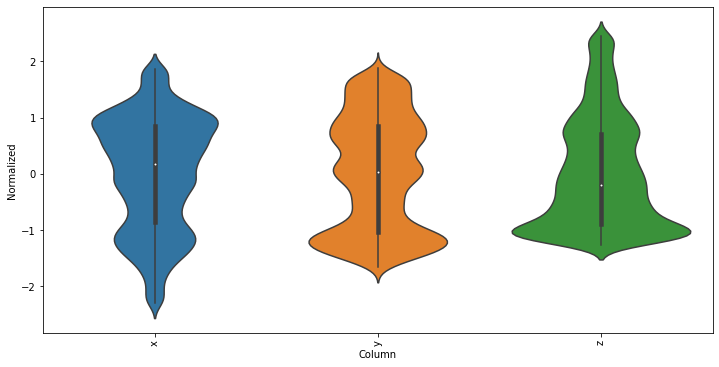

In [82]:
df_std = (data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data.keys(), rotation=90)

#Split windows

## Single output

In [161]:
def split(data, win_size = 30, win_shift = 6, offset = 1, column = 'x'):
  
  rows = np.arange(win_size, len(train_df) - win_shift- 1, win_shift)
  
  samples = np.zeros((len(rows), win_size, data.shape[-1]))
  
  targets = np.zeros((len(rows),))
  
  for j, row in enumerate(rows):
    samples[j] = train_df[j * win_shift: row]
    targets[j] = train_df[row: row + offset][column]
   
  return samples, targets

In [162]:
x_train, y_train = split(train_df)
x_val  , y_val  = split(val_df)

## Multiple output

In [155]:
def split(data, win_size=30, win_shift=6, offset=1):
  
  rows = np.arange(win_size, len(train_df) - win_shift- 1, win_shift)
  
  samples = np.zeros((len(rows), win_size, data.shape[-1]))
  
  targets = np.zeros((len(rows), data.shape[-1]))
  
  for j, row in enumerate(rows):
    samples[j] = train_df[j * win_shift: row]
    targets[j] = train_df[row: row + offset]
   
  return samples, targets

In [156]:
m_x_train, m_y_train = split(train_df)
m_x_val  , m_y_val  = split(val_df)

# Single-output Models

## Dense

In [148]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

linear.compile(loss = 'mae', optimizer='adam')
history = linear.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=32, shuffle=False)

Epoch 1/10
529/529 [==============================] - 3s 5ms/step - loss: 0.6221 - val_loss: 0.5730
Epoch 2/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5761 - val_loss: 0.5774
Epoch 3/10
529/529 [==============================] - 3s 6ms/step - loss: 0.5781 - val_loss: 0.5758
Epoch 4/10
529/529 [==============================] - 3s 5ms/step - loss: 0.5757 - val_loss: 0.5769
Epoch 5/10
529/529 [==============================] - 3s 5ms/step - loss: 0.5742 - val_loss: 0.5756
Epoch 6/10
529/529 [==============================] - 2s 4ms/step - loss: 0.5726 - val_loss: 0.5745
Epoch 7/10
529/529 [==============================] - 3s 5ms/step - loss: 0.5711 - val_loss: 0.5706
Epoch 8/10
529/529 [==============================] - 3s 5ms/step - loss: 0.5711 - val_loss: 0.5717
Epoch 9/10
529/529 [==============================] - 3s 5ms/step - loss: 0.5714 - val_loss: 0.5752
Epoch 10/10
529/529 [==============================] - 3s 5ms/step - loss: 0.5703 - val_loss: 0.5734

## Multi-step

In [149]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

multi_step_dense.compile(loss = 'mae', optimizer='adam')
history = multi_step_dense.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=32, shuffle=False)

Epoch 1/10
529/529 [==============================] - 2s 3ms/step - loss: 0.6352 - val_loss: 0.5720
Epoch 2/10
529/529 [==============================] - 2s 4ms/step - loss: 0.5823 - val_loss: 0.6021
Epoch 3/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5677 - val_loss: 0.5989
Epoch 4/10
529/529 [==============================] - 2s 4ms/step - loss: 0.5630 - val_loss: 0.5857
Epoch 5/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5622 - val_loss: 0.5982
Epoch 6/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5611 - val_loss: 0.5734
Epoch 7/10
529/529 [==============================] - 2s 4ms/step - loss: 0.5578 - val_loss: 0.5778
Epoch 8/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5546 - val_loss: 0.5823
Epoch 9/10
529/529 [==============================] - 2s 4ms/step - loss: 0.5528 - val_loss: 0.5590
Epoch 10/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5484 - val_loss: 0.5827

## Convolutional

In [151]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(6,),
                           activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

conv_model.compile(loss = 'mae', optimizer='adam')
history = conv_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=32, shuffle=False)

Epoch 1/10
529/529 [==============================] - 58s 32ms/step - loss: 0.4894 - val_loss: 0.3520
Epoch 2/10
529/529 [==============================] - 16s 29ms/step - loss: 0.3227 - val_loss: 0.3017
Epoch 3/10
529/529 [==============================] - 16s 30ms/step - loss: 0.2890 - val_loss: 0.2811
Epoch 4/10
529/529 [==============================] - 16s 29ms/step - loss: 0.2738 - val_loss: 0.2837
Epoch 5/10
529/529 [==============================] - 16s 30ms/step - loss: 0.2674 - val_loss: 0.2767
Epoch 6/10
529/529 [==============================] - 16s 31ms/step - loss: 0.2623 - val_loss: 0.2678
Epoch 7/10
529/529 [==============================] - 16s 30ms/step - loss: 0.2603 - val_loss: 0.2576
Epoch 8/10
529/529 [==============================] - 16s 30ms/step - loss: 0.2563 - val_loss: 0.2747
Epoch 9/10
529/529 [==============================] - 16s 30ms/step - loss: 0.2535 - val_loss: 0.2504
Epoch 10/10
529/529 [==============================] - 16s 30ms/step - loss: 0.251

## LSTM

In [324]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, recurrent_dropout=0.25, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(loss = 'mae', optimizer='adam')
history = lstm_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=32, shuffle=False)

604/604 [==============================] - 31s 42ms/step - loss: 0.1729 - val_loss: 0.1238


In [325]:
lstm_model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 30, 16)            1280      
                                                                 
 dropout_3 (Dropout)         (None, 30, 16)            0         
                                                                 
 lstm_71 (LSTM)              (None, 8)                 800       
                                                                 
 dense_93 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________


In [163]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(loss = 'mae', optimizer='adam')
history = lstm_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=32, shuffle=False)

Epoch 1/10
529/529 [==============================] - 23s 33ms/step - loss: 0.3468 - val_loss: 0.2749
Epoch 2/10
529/529 [==============================] - 17s 32ms/step - loss: 0.2135 - val_loss: 0.2244
Epoch 3/10
529/529 [==============================] - 16s 31ms/step - loss: 0.1855 - val_loss: 0.1794
Epoch 4/10
529/529 [==============================] - 17s 31ms/step - loss: 0.1698 - val_loss: 0.1551
Epoch 5/10
529/529 [==============================] - 17s 31ms/step - loss: 0.1525 - val_loss: 0.1588
Epoch 6/10
529/529 [==============================] - 17s 31ms/step - loss: 0.1398 - val_loss: 0.1284
Epoch 7/10
529/529 [==============================] - 17s 32ms/step - loss: 0.1324 - val_loss: 0.1636
Epoch 8/10
529/529 [==============================] - 18s 34ms/step - loss: 0.1314 - val_loss: 0.1272
Epoch 9/10
529/529 [==============================] - 17s 32ms/step - loss: 0.1242 - val_loss: 0.1398
Epoch 10/10
529/529 [==============================] - 17s 32ms/step - loss: 0.128

# Multi-output Models


## Multilinear

In [134]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(1*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([1, num_features])
])

multi_linear_model.compile(loss = 'mae', optimizer='adam')
history = multi_linear_model.fit(m_x_train, m_y_train, epochs=10, validation_data=(m_x_val, m_y_val), verbose = 1, batch_size=32, shuffle=False)

Epoch 1/10
529/529 [==============================] - 3s 4ms/step - loss: 0.7547 - val_loss: 0.6794
Epoch 2/10
529/529 [==============================] - 2s 3ms/step - loss: 0.6429 - val_loss: 0.6143
Epoch 3/10
529/529 [==============================] - 2s 4ms/step - loss: 0.6010 - val_loss: 0.5890
Epoch 4/10
529/529 [==============================] - 2s 4ms/step - loss: 0.5841 - val_loss: 0.5790
Epoch 5/10
529/529 [==============================] - 2s 4ms/step - loss: 0.5775 - val_loss: 0.5752
Epoch 6/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5750 - val_loss: 0.5738
Epoch 7/10
529/529 [==============================] - 2s 4ms/step - loss: 0.5741 - val_loss: 0.5733
Epoch 8/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5738 - val_loss: 0.5731
Epoch 9/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5736 - val_loss: 0.5731
Epoch 10/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5736 - val_loss: 0.5730

##Dense

In [133]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([1, num_features])
])

multi_dense_model.compile(loss = 'mae', optimizer='adam')
history = multi_dense_model.fit(m_x_train, m_y_train, epochs=10, validation_data=(m_x_val, m_y_val), verbose = 1, batch_size=32, shuffle=False)

Epoch 1/10
529/529 [==============================] - 3s 4ms/step - loss: 0.6185 - val_loss: 0.5902
Epoch 2/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5821 - val_loss: 0.5844
Epoch 3/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5781 - val_loss: 0.5881
Epoch 4/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5770 - val_loss: 0.5844
Epoch 5/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5760 - val_loss: 0.5854
Epoch 6/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5761 - val_loss: 0.5838
Epoch 7/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5748 - val_loss: 0.5971
Epoch 8/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5746 - val_loss: 0.5948
Epoch 9/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5742 - val_loss: 0.5897
Epoch 10/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5716 - val_loss: 0.5910

## Convolutional

In [137]:
CONV_WIDTH = 5
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([1, num_features])
])

multi_dense_model.compile(loss = 'mae', optimizer='adam')
history = multi_dense_model.fit(m_x_train, m_y_train, epochs=10, validation_data=(m_x_val, m_y_val), verbose = 1, batch_size=32, shuffle=False)

Epoch 1/10
529/529 [==============================] - 3s 4ms/step - loss: 0.5672 - val_loss: 0.5774
Epoch 2/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5690 - val_loss: 0.5757
Epoch 3/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5680 - val_loss: 0.5735
Epoch 4/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5674 - val_loss: 0.5784
Epoch 5/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5656 - val_loss: 0.5754
Epoch 6/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5670 - val_loss: 0.5757
Epoch 7/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5669 - val_loss: 0.5743
Epoch 8/10
529/529 [==============================] - 2s 4ms/step - loss: 0.5658 - val_loss: 0.5742
Epoch 9/10
529/529 [==============================] - 2s 5ms/step - loss: 0.5658 - val_loss: 0.5727
Epoch 10/10
529/529 [==============================] - 2s 3ms/step - loss: 0.5667 - val_loss: 0.5712

## LSTM

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

multi_lstm_model.compile(loss = 'mae', optimizer='adam')
history = multi_lstm_model.fit(m_x_train, m_y_train, epochs=100, validation_data=(m_x_val, m_y_val), verbose = 1, batch_size=32, shuffle=False)

# Autoencoder Multi-output


In [261]:
data = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-1/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-1/test.csv')
n_past = 30
n_future = 1
n_features = 3

In [262]:
n = len(data)
train_df = data[0:int(n*0.8)]
val_df = data[int(n*0.8):]
test_df = data_test


In [264]:
train_df.shape, test_df.shape, val_df.shape

((115928, 3), (148371, 3), (28983, 3))

## Scaling values


In [ ]:
from sklearn.preprocessing import MinMaxScaler

train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

val = val_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(val[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    val[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [ ]:
test[:10]

In [274]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [275]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_val, y_val = split_series(val.values, n_past, n_future)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
y_val[:10]

## Model 1

In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(16, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(16, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

In [280]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())
history_e1d1=model_e1d1.fit(X_train, y_train, epochs=10, validation_data=(X_val,y_val), batch_size=32, verbose=1, callbacks=[reduce_lr])

Epoch 1/10
3622/3622 [==============================] - 66s 17ms/step - loss: 0.0725 - val_loss: 0.0513 - lr: 0.0010
Epoch 2/10
3622/3622 [==============================] - 71s 20ms/step - loss: 0.0552 - val_loss: 0.0516 - lr: 9.0000e-04
Epoch 3/10
3622/3622 [==============================] - 61s 17ms/step - loss: 0.0546 - val_loss: 0.0504 - lr: 8.1000e-04
Epoch 4/10
3622/3622 [==============================] - 61s 17ms/step - loss: 0.0543 - val_loss: 0.0504 - lr: 7.2900e-04
Epoch 5/10
3622/3622 [==============================] - 61s 17ms/step - loss: 0.0541 - val_loss: 0.0495 - lr: 6.5610e-04
Epoch 6/10
3622/3622 [==============================] - 61s 17ms/step - loss: 0.0540 - val_loss: 0.0496 - lr: 5.9049e-04
Epoch 7/10
3622/3622 [==============================] - 60s 17ms/step - loss: 0.0538 - val_loss: 0.0495 - lr: 5.3144e-04
Epoch 8/10
3622/3622 [==============================] - 61s 17ms/step - loss: 0.0537 - val_loss: 0.0499 - lr: 4.7830e-04
Epoch 9/10
3622/3622 [==============

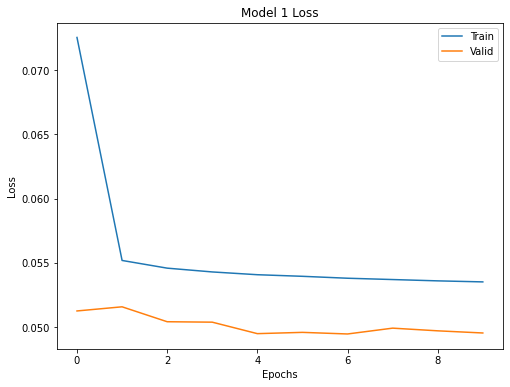

In [281]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("Model 1 Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [282]:
pred1_e1d1 = model_e1d1.predict(X_test)

In [ ]:
pred1_e1d1[:10]

## Model 2


In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(16,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(16, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(16, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(16, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

In [286]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())
history_e2d2=model_e2d2.fit(X_train, y_train, epochs=10, validation_data=(X_val,y_val), batch_size=32, verbose=1, callbacks=[reduce_lr])

Epoch 1/10
3622/3622 [==============================] - 121s 31ms/step - loss: 0.0760 - val_loss: 0.0525 - lr: 0.0010
Epoch 2/10
3622/3622 [==============================] - 114s 32ms/step - loss: 0.0559 - val_loss: 0.0515 - lr: 9.0000e-04
Epoch 3/10
3622/3622 [==============================] - 112s 31ms/step - loss: 0.0549 - val_loss: 0.0509 - lr: 8.1000e-04
Epoch 4/10
3622/3622 [==============================] - 112s 31ms/step - loss: 0.0545 - val_loss: 0.0500 - lr: 7.2900e-04
Epoch 5/10
3622/3622 [==============================] - 112s 31ms/step - loss: 0.0542 - val_loss: 0.0502 - lr: 6.5610e-04
Epoch 6/10
3622/3622 [==============================] - 112s 31ms/step - loss: 0.0541 - val_loss: 0.0498 - lr: 5.9049e-04
Epoch 7/10
3622/3622 [==============================] - 111s 31ms/step - loss: 0.0539 - val_loss: 0.0497 - lr: 5.3144e-04
Epoch 8/10
3622/3622 [==============================] - 112s 31ms/step - loss: 0.0537 - val_loss: 0.0497 - lr: 4.7830e-04
Epoch 9/10
3622/3622 [======

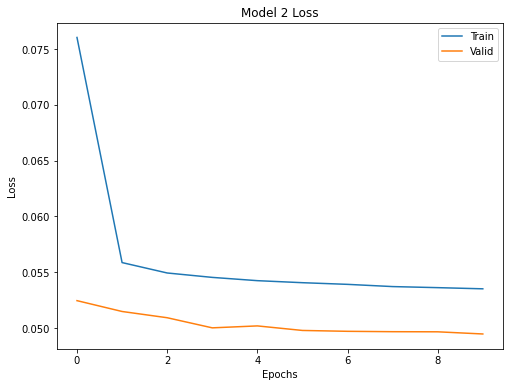

In [287]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("Model 2 Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [288]:
pred1_e2d2 = model_e2d2.predict(X_test)

## Revert Scaling

In [289]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index] = scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred1_e2d2[:,:,index] = scaler.inverse_transform(pred1_e2d2[:,:,index])
    y_test[:,:,index] = scaler.inverse_transform(y_test[:,:,index])


In [290]:
pred1_e1d1[:5]

array([[[ 585.4255 , -547.52826, -471.8596 ]],

       [[ 582.0125 , -394.66592, -736.768  ]],

       [[ 584.43524, -421.95123, -714.0667 ]],

       [[ 581.8892 , -418.2416 , -719.7282 ]],

       [[ 580.83344, -417.93356, -720.3462 ]]], dtype=float32)

In [291]:
pred1_e2d2[:5]

array([[[ 579.4152 , -550.7389 , -480.36356]],

       [[ 581.8531 , -397.16843, -738.8021 ]],

       [[ 587.2816 , -420.14142, -709.6851 ]],

       [[ 583.6196 , -414.14038, -716.38416]],

       [[ 583.82764, -413.1983 , -719.54346]]], dtype=float32)

(148341, 1, 3)

In [295]:
from sklearn.metrics import mean_absolute_error

for index,i in enumerate(train_df.columns):
  print(i)
  print("Model 1 : ",mean_absolute_error(y_test[:, 0, index], pred1_e1d1[:,0 ,index]),end=", \r\n")
  print("Model 2 : ",mean_absolute_error(y_test[:, 0, index], pred1_e2d2[:,0 ,index]))
  print()
  print()

x
Model 1 :  73.39843327907987, 
Model 2 :  73.7104009338469


y
Model 1 :  81.10904747921978, 
Model 2 :  80.81932926068183


z
Model 1 :  74.34306233270308, 
Model 2 :  74.68162238137926




# Autoencoder single-output


In [309]:
data = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-1/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project/Task-1/test.csv')
n_past = 30
n_future = 1
n_features = 3

n = len(data)
train_df = data[0:int(n*0.8)]
val_df = data[int(n*0.8):]
test_df = data_test

In [ ]:
from sklearn.preprocessing import MinMaxScaler

train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

val = val_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(val[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    val[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [318]:
x_train, y_train = split(train)
x_val  , y_val  = split(val)

In [315]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_val, y_val = split_series(val.values, n_past, n_future)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], n_features))

In [320]:
x_train.shape, y_train.shape

((19316, 30, 3), (19316,))

In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(16, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(16, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs, decoder_outputs1)
#
model_e1d1.summary()

In [333]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())
history_e1d1=model_e1d1.fit(x_train, y_train, epochs=5, validation_data=(x_val,y_val), batch_size=32, verbose=1, callbacks=[reduce_lr])

Epoch 1/5
604/604 [==============================] - 17s 21ms/step - loss: 0.4439 - val_loss: 0.4333 - lr: 0.0010
Epoch 2/5
604/604 [==============================] - 11s 19ms/step - loss: 0.4402 - val_loss: 0.4331 - lr: 9.0000e-04
Epoch 3/5
604/604 [==============================] - 11s 19ms/step - loss: 0.4404 - val_loss: 0.4302 - lr: 8.1000e-04
Epoch 4/5
604/604 [==============================] - 11s 19ms/step - loss: 0.4401 - val_loss: 0.4336 - lr: 7.2900e-04
Epoch 5/5
604/604 [==============================] - 12s 19ms/step - loss: 0.4403 - val_loss: 0.4309 - lr: 6.5610e-04
